In [5]:
import sys
sys.path.append("..")

import numpy as np
from tqdm import tqdm
from scipy import signal
from pathlib import Path
from utils.plot_utils import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sympy import Symbol, zeros, Function, MatrixSymbol

In [6]:
from julia import Main
Main.eval("Threads.nthreads()")

10

In [7]:
Main.eval("""using Waveforms""")
Main.eval("""using DifferentialEquations""")
Main.eval("""using BenchmarkTools""")
Main.eval("""
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())
""")

<PyCall.jlwrap Logging.ConsoleLogger(Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000934) open, 0 bytes waiting), Info, Logging.default_metafmt, true, 0, Dict{Any,Int64}())>

In [8]:
Main.eval("""
function square_wave(t::Float64, frequency::Float64, phase::Float64)
    0.5.*(1 .+ squarewave(2*pi.*frequency.*t .+ phase))
end
""")

<PyCall.jlwrap square_wave>

In [9]:
# reading from file
with open('../ode_fun_mu1.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [10]:
print(ode_fun[:700])


function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω = p[1]
		Ωᶜ = conj(Ω)
		νp = p[2]
		Ω1 = p[3]
		Ω1ᶜ = conj(Ω1)
		νp1 = p[4]
		Δ = p[5]
		Plx = square_wave(t, νp, 3.141592653589793)
		Plz = square_wave(t, νp, 0.0)    
		Pm1y = square_wave(t, νp1, 1.5707963267948966)
		Pm1z = square_wave(t, νp1, 4.71238898038469)
		du[1,1] = 3367347.38920463*ρ[37,37] + 3367525.85757619*ρ[38,38] + 3367704.32982946*ρ[39,39]
		du[1,2] = -83545.9813842773*1im*ρ[1,2]
		du[1,3] = -83566.3651275635*1im*ρ[1,3]
		du[1,4] = -83586.7483215332*1im*ρ[1,4]
		du[1,5] = -1.0*1im*(0.333333330908845*1im*Ω1ᶜ*ρ[1,17]*Pm1y - 0.471404517203288*Ω1ᶜ*ρ[1,18]*Pm1z + 0.333333330908771*1im*Ω1ᶜ*ρ[1,19]*Pm1y - 83783184618.4029*ρ[


In [11]:
# making the function in Julia
Main.eval(ode_fun)

<PyCall.jlwrap Lindblad_rhs!>

In [12]:
data_dir = Path('../stored_data')

fnames = ['rho_ini']

for fname in fnames:
    if fname == 'rho_ini':
        ρ_ini = np.load(data_dir / (fname + '.npy'))
    else:
        globals()[fname] = np.load(data_dir / (fname + '.npy'))

In [106]:
de_main = -0.39444661382277774 # main dipole transition moment

Γ = 1/(100e-9)
Ω =  1*Γ*abs(de_main)
ωp = Γ
νp = ωp/(2*np.pi)
νp1 = νp
Ω1 = 1*Γ*abs(de_main)
Δ = 0

Main.Ω = Ω
Main.νp = νp
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Δ = Δ
Main.Γ = Γ

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("p = [Ω, νp, Ω1, νp1, Δ]")

array([3944466.13822778, 1591549.43091895, 3944466.13822778,
       1591549.43091895,       0.        ])

In [14]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@time Lindblad_rhs!(du, ρ_ini, [Ω, νp, Ω1, νp1, Δ], 0.)
tmp = 0
""")

Wall time: 4min 15s


0

### Polarization switching frequency scan

In [107]:
Main.freqs = np.logspace(-3,1,201)*1e6
Main.params = Main.freqs

In [108]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.615827620635e9, 1.615827620635e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000934) open, 0 bytes waiting), 0, 0, 0)>

In [109]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [110]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [111]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)


function prob_func(prob,i,repeat)
    remake(prob,p=[Ω; params[i]; Ω1; params[i]; Δ])
end
""")

<PyCall.jlwrap prob_func>

In [112]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [113]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

79.0443764

In [114]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [118]:
result_freq_scan = np.empty([len(Main.params),40], dtype = 'complex')
result_freq_scan[:,0] = Main.params.copy()
result_freq_scan[:,1:] = ens_u.copy()

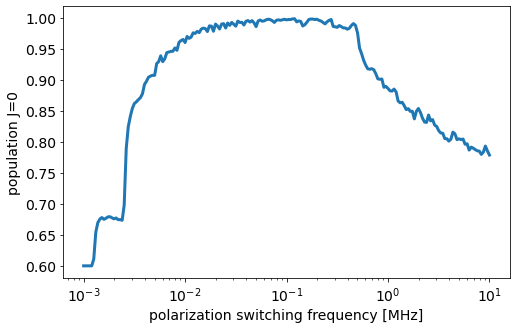

In [179]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(result_freq_scan[:,0].real/1e6, result_freq_scan[:,1:5].sum(axis = 1).real, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.set_xscale('log')

set_fontsize(ax, 14)

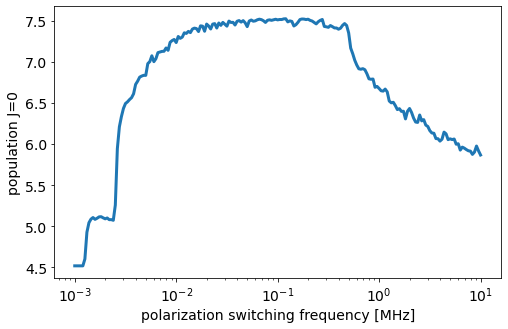

In [180]:
ratio = result_freq_scan[:,1:5].sum(axis = 1).real/np.diag(ρ_ini)[:4].sum().real
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(result_freq_scan[:,0].real/1e6, ratio, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.set_xscale('log')

set_fontsize(ax, 14)

### Polarization switching frequency scan (no microwaves)

In [166]:
Main.freqs = np.logspace(-3,1,201)*1e6
Main.params = Main.freqs

In [167]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.615829779928e9, 1.615829779928e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000934) open, 0 bytes waiting), 0, 0, 0)>

In [168]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [169]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [195]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)


function prob_func(prob,i,repeat)
    remake(prob,p=[Ω; params[i]; 0; 0; 0])
end
""")

<PyCall.jlwrap prob_func>

In [196]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [197]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

71.996414

In [198]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

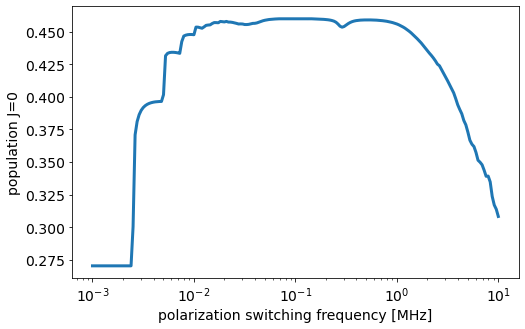

In [199]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/1e6, ens_u[:,:4].sum(axis = 1).real, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.set_xscale('log')

set_fontsize(ax, 14)

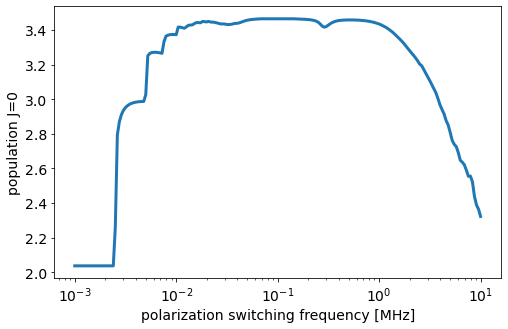

In [200]:
ratio = ens_u[:,:4].sum(axis = 1).real/np.diag(ρ_ini)[:4].sum().real

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/1e6, ratio, lw = 3)

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.set_xscale('log')

set_fontsize(ax, 14)

### Polarization switching frequency scan for different Ω and Ω1

In [126]:
Main.freqs = np.logspace(-3,1,201)*1e6
Main.Ωs = np.arange(1,11,1)*Ω
params = np.zeros([len(Main.freqs)*len(Main.Ωs), 2])
params[:,0] = np.repeat(Main.Ωs, len(Main.freqs))
params[:,1] = np.tile(Main.freqs, len(Main.Ωs))
Main.params = params

In [127]:
# defining a progress bar to keep track of the ODE ensemble solver progress
Main.eval("using ProgressMeter")
Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

<PyCall.jlwrap Progress(50, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), 1.0, 0, 1.615827830459e9, 1.615827830459e9, false, "ODE Solving ", 50, BarGlyphs('|', '█', '█', ' ', '|'), :green, Base.TTY(Base.Libc.WindowsRawSocket(0x0000000000000934) open, 0 bytes waiting), 0, 0, 0)>

In [128]:
# function called every time on the when an ODE solve is ready
# only save the diagonal of each solution (e.g. populations in each state)
Main.eval("""
function output_func(sol,i)
    next!(pbar)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

<PyCall.jlwrap output_func>

In [129]:
# μseconds traversal time
(1.5*25.4 * 1e-3)/184 * 1e6

207.06521739130432

In [130]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)


function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; params[i,2]; Ω1; params[i,2]; Δ])
end
""")

<PyCall.jlwrap prob_func>

In [131]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [132]:
# starting the parallel ensemble simulation
# precision of the solver is increased resulting in a longer runtime
# probably not necessary
Main.eval("pbar.counter = 0")
Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleThreads(), save_start = true, save_end = true, 
            save_everystep = false; trajectories = trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

373.620294699

In [133]:
ens_u = Main.eval("sim.u")
ens_u = np.array(ens_u)

In [134]:
result_freq_Ω_scan = np.empty([len(Main.params),41], dtype = 'complex')
result_freq_Ω_scan[:,:2] = Main.params.copy()
result_freq_Ω_scan[:,2:] = ens_u.copy()

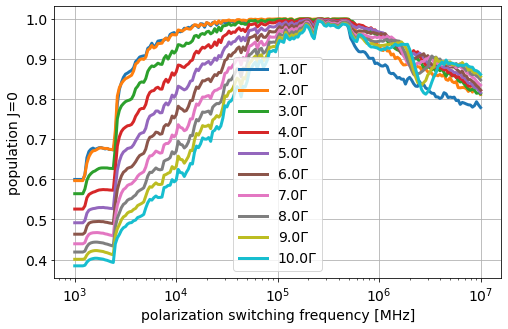

In [181]:
fig, ax = plt.subplots(figsize = (8,5))

for Ωi in Main.Ωs:
    m = Ωi == result_freq_Ω_scan[:,0].real
    f = result_freq_Ω_scan[m][:,1].real
    p = result_freq_Ω_scan[m][:,2:6].sum(axis = 1).real
    ax.plot(f, p, lw = 3, label = f"{Ωi/Γ/abs(de_main):.1f}Γ")

ax.legend(fontsize = 14)
ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('population J=0')

ax.grid(True)
ax.set_xscale('log')

set_fontsize(ax, 14)

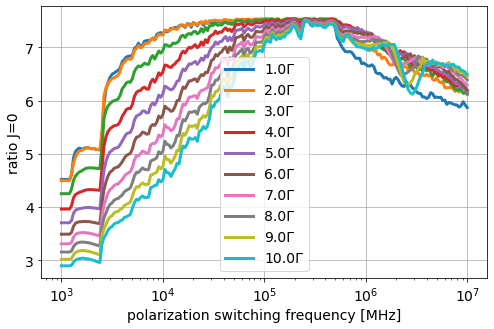

In [182]:
fig, ax = plt.subplots(figsize = (8,5))

for Ωi in Main.Ωs:
    m = Ωi == result_freq_Ω_scan[:,0].real
    f = result_freq_Ω_scan[m][:,1].real
    r = result_freq_Ω_scan[m][:,2:6].sum(axis = 1).real / np.diag(ρ_ini)[:4].sum().real
    ax.plot(f, r, lw = 3, label = f"{Ωi/Γ/abs(de_main):.1f}Γ")

ax.legend(fontsize = 14)
ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('ratio J=0')

ax.grid(True)

ax.set_xscale('log')

set_fontsize(ax, 14)

### Check a single scan at 1 MHz

In [204]:
Main.Ω = 1*Γ*abs(de_main)
Main.νp = 1e6
Main.Ω1 = 1*Γ*abs(de_main)
Main.νp1 = 1e6
Main.Δ = 0
Main.eval("p = [Ω, νp, Ω1, νp1, Δ]");

In [205]:
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [215]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), dt = 1e-9, adaptive=true)
tmp = 0
""")
#, abstol = 5e-7, reltol = 5e-4

Wall time: 11min 30s


0

6.731937316340334


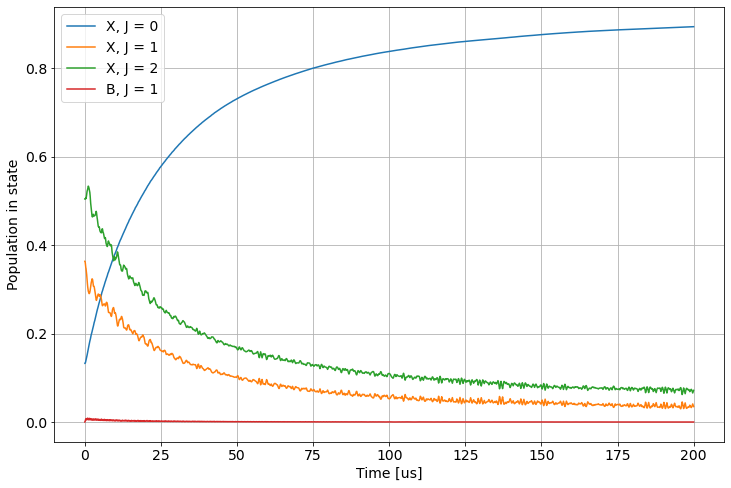

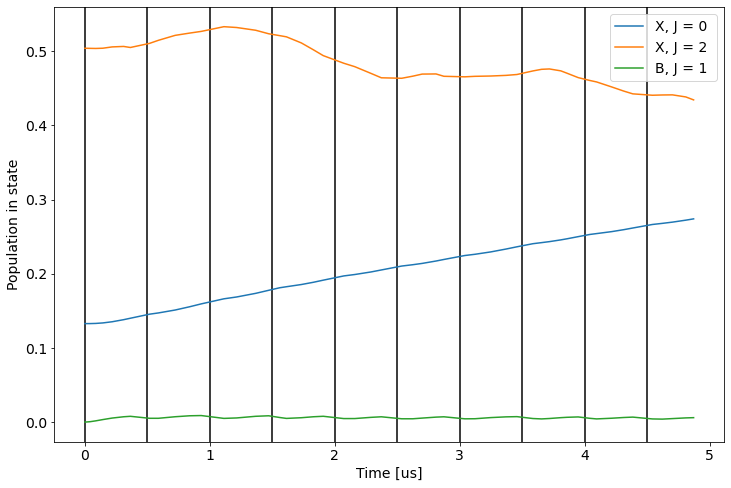

In [216]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")


#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

print(P0[-1]/P0[0])

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)


m = t_array <= 5e6/(Main.νp)/1e6

t_array = t_array[m]
pop_results = pop_results[:,m]
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
for i in range(10):
    ax.axvline(i*1e6/Main.νp/2, zorder = 0, color = 'k')

In [52]:
Main.Ω = 1*Γ*abs(de_main)
Main.νp = .5e6
Main.Ω1 = 1*Γ*abs(de_main)
Main.νp1 = .5e6
Main.Δ = 0
Main.eval("p = [Ω, νp, Ω1, νp1, Δ]");

array([3944466.13822778,  500000.        , 3944466.13822778,
        500000.        ,       0.        ])

In [53]:
Main.eval("""
tspan = (0.0f0, 200e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [54]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), dt = 1e-9, adaptive=true)
tmp = 0
""")
#, abstol = 5e-7, reltol = 5e-4

Wall time: 6.79 s


0

7.351835810009305


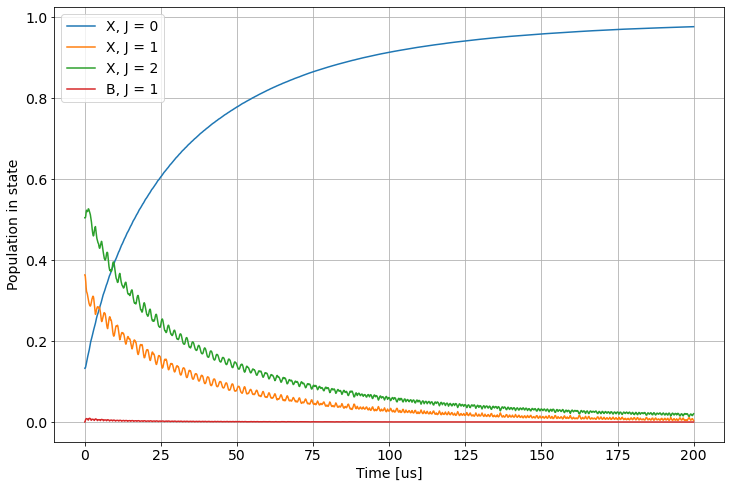

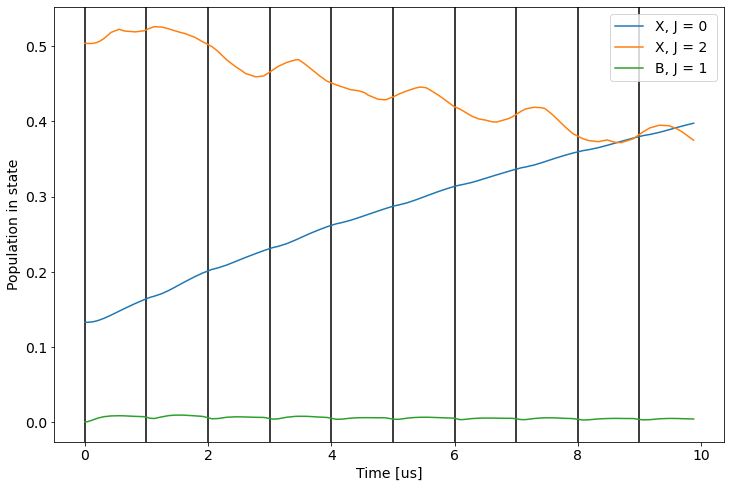

In [55]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")


#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

print(P0[-1]/P0[0])

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)


m = t_array <= 5e6/(Main.νp)/1e6

t_array = t_array[m]
pop_results = pop_results[:,m]
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0, label = 'X, J = 0')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1 ')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
for i in range(10):
    ax.axvline(i*1e6/Main.νp/2, zorder = 0, color = 'k')

### Verify decay time (to check for 2π errors or similar)

In [88]:
Main.Ω = 0.
Main.νp = 0.
Main.Ω1 = 0.
Main.νp1 = 0.
Main.Δ = 0.
Main.eval("p = [Ω, νp, Ω1, νp1, Δ]")

array([0., 0., 0., 0., 0.])

In [89]:
ρ_ini_exc = np.zeros(ρ_ini.shape, ρ_ini.dtype)
ρ_ini_exc[-1,-1] = 1
Main.ρ_ini_exc = ρ_ini_exc

In [90]:
Main.eval("""
tspan = (0.0f0, 500e-9)
prob = ODEProblem(Lindblad_rhs!,ρ_ini_exc,tspan,p)
tmp = 0
""")

0

In [91]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), dt = 1e-9, adaptive=false)
tmp = 0
""")
#, abstol = 5e-7, reltol = 5e-4

Wall time: 244 ms


0

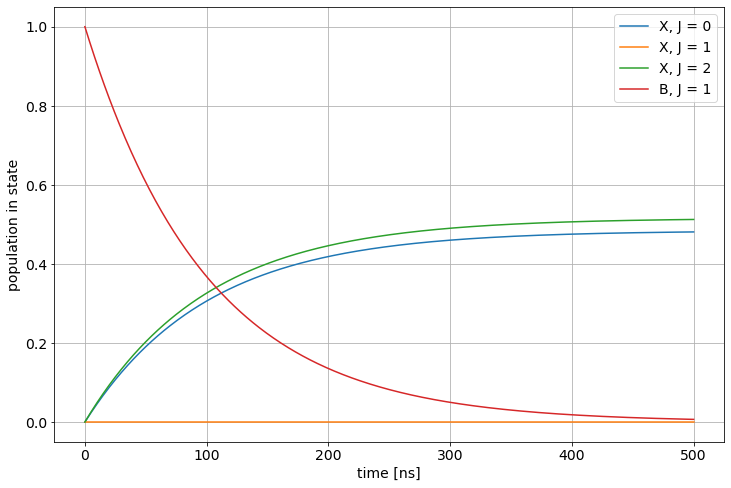

In [92]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("""sol.t""")


#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
PB1 = np.sum(pop_results[36:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
# ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
# ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e9, P0, label = 'X, J = 0')
ax.plot(t_array*1e9, P1, label = 'X, J = 1')
ax.plot(t_array*1e9, P2, label = 'X, J = 2')
ax.plot(t_array*1e9, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("time [ns]", fontsize = 14)
ax.set_ylabel("population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.grid(True)